### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import os
import itertools
import re
import random
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import metrics as s_metrics

# Define figure defaults
sns.set_style("white")
sns.set_context("paper", font_scale=1.875)

# Define random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [98]:
# Define folder that contains the dhg dataset
DHG_PATH = os.path.join("..", "data", "DHG")
# Define folder that contains raw data
DHG_RAW_DATA = os.path.join(DHG_PATH, "raw")
# Define folder to save processed data
DHG_PROCESSED_DATA = os.path.join(DHG_PATH, "processed")
# Define file that contains dhg metadata
METADATA_PATH = os.path.join(DHG_PATH, "metadata.csv")
# Define path to save plots and results
FIGURES_PATH = os.path.join('.', "figures_no_shift_seed_277")
# Read metadata csv
metadata_df = pd.read_csv(METADATA_PATH)

### ***Correlation plots***

Next, let's get define correlation plots we want to create. We start with creating multiple helper functions:

In [3]:
def plot_corr_matrix(
    corr_df: pd.DataFrame, y_label: str, x_label: str,
    mark_biopsies: bool = False, sort_biopsies: bool = False,
    figsize: Tuple[float, float] = (11.69, 8.27), cbar: bool = False,
    annot: bool = False
) -> Tuple[plt.Figure, plt.Axes]:
  """Function to plot correlation matrix.

  Args:
      corr_df (pd.DataFrame): Correlation matrix.
      y_label (str): Y axis label.
      x_label (str): X axis label.
      mark_biopsies (bool, optional): Indicator if to mark biopsies from the
          same patient in red box. Defaults to False.
      sort_biopsies (bool, optional): Indicator if to sort biopsies in figure.
          Defaults to False.
      figsize (Tuple[float, float], optional): Figure size. Defaults to
          (11.69, 8.27).
      cbar (bool, optional): Indicator to whether to draw a color bar. Defaults
          to False.
      annot (bool, optional): Indicator to whether to write the data value in
          each cell. Defaults to False.

  Returns:
      Tuple[plt.Figure, plt.Axes]: Figure and axes.
  """
  # Create figure
  fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)

  # Sort biopsies by their number
  if sort_biopsies:
    index_keys = corr_df.index.to_series(
    ).apply(lambda s: int(re.sub(r"HG |-s|-r|_.", "", s))).sort_values().index
    col_keys = corr_df.columns.to_series(
    ).apply(lambda s: int(re.sub(r"HG |-s|-r|_.", "", s))).sort_values().index
    corr_df = corr_df.loc[index_keys.to_list(), col_keys.to_list()]

  # Plot correlation matrix
  ax = sns.heatmap(
      corr_df, annot=annot, cmap="YlGn", fmt=".2f", vmin=-1, vmax=1,
      linewidth=.5, linecolor='w', square=True, cbar=cbar, ax=ax
  )
  ax.set_ylabel(y_label.capitalize())
  ax.set_xlabel(x_label.capitalize())

  # Mark cells of biopsies from the same patient
  if mark_biopsies:
    for index_i, i in enumerate(corr_df.columns):
      for index_j, j in enumerate(corr_df.index):
        i_num = re.sub(r"HG |-s|-r|_.", "", i)
        j_num = re.sub(r"HG |-s|-r|_.", "", j)
        if i_num == j_num:
          ax.add_patch(
              Rectangle(
                  (index_i, index_j), 1, 1, fill=False, edgecolor="red", lw=2
              )
          )
  return fig, ax


def plot_corr_ranks(
    corr_df: pd.DataFrame, figsize: Tuple[float, float] = (11.69, 8.27)
) -> Tuple[plt.Figure, plt.Axes]:
  """Function to plot correlation ranks for pair biopsies.

  Args:
      corr_df (pd.DataFrame): Correlation matrix.
      figsize (Tuple[float, float], optional): Figure size. Defaults to
          (11.69, 8.27).

  Returns:
      Tuple[plt.Figure, plt.Axes]: Figure and axes.
  """
  # Get ranks of correlation matrix
  ranks = corr_df.rank(axis=0, method="min", ascending=False).astype(int)
  # Define list to save pair ranks
  pair_ranks = []
  # Get ranks of pairs
  for i in corr_df.columns:
    for j in corr_df.index:
      i_num = re.sub(r"HG |-s|-r|_.", "", i)
      j_num = re.sub(r"HG |-s|-r|_.", "", j)
      if i_num == j_num:
        pair_ranks.append(ranks.loc[j, i])
  # Create figure
  fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)
  # Plot pair correlation rank count
  ax = sns.countplot(
      data=pd.DataFrame({"ranks": pair_ranks}), x="ranks", ax=ax,
      color="#3274a1"
  )
  ax.set_ylabel("Count")
  ax.set_xlabel("Pairs correlation rank")
  ax.set_ylim((0, 21))
  return fig, ax


def plot_corr_distribution(
    corr_df: pd.DataFrame, figsize: Tuple[float, float] = (11.69, 8.27)
) -> Tuple[plt.Figure, plt.Axes]:
  """Function to plot correlation distribution.

  Args:
      corr_df (pd.DataFrame): Correlation matrix.
      figsize (Tuple[float, float], optional): Figure size. Defaults to
          (11.69, 8.27).

  Returns:
      Tuple[plt.Figure, plt.Axes]: Figure and axes.
  """
  # Create figure
  fig, ax = plt.subplots(1, 1, figsize=figsize, tight_layout=True)
  # Plot pair correlation rank count
  ax = sns.histplot(
      corr_df.values.reshape(-1), bins=np.arange(-0.05, 1.1, 0.1),
      stat="probability", ax=ax, color="#3274a1"
  )
  ax.set_ylabel("Probability")
  ax.set_xlabel("Correlation")
  ax.set_ylim((0, 1))
  return fig, ax

Next, let's create correlation plots:

In [4]:
# Define path to correlation csvs
correlation_path = os.path.join(FIGURES_PATH, "correlations")
# Define order of sections and replicas in correlations matrix
r_order = []
s_order = []
for group_name, group in metadata_df.groupby('file_name'):
  if group.sample_type.iloc[0] == "section":
    s_order += group.sample_file_name.to_list()
  else:
    r_order += group.sample_file_name.to_list()
# Loop over all files in path
for file in os.listdir(correlation_path):
  # Check if file is csv
  if file.endswith(".csv"):
    # Get file name
    file_name = os.path.splitext(file)[0]
    # Get image type (before and after correction), and spectra types
    # (tissue, background)
    image_type, spectra_a_type, spectra_b_type = file_name.split("_")
    # Loop over combinations of replica and section
    for biopsy_combination in list(
        itertools.combinations_with_replacement(["s", "r"], 2)
    ):
      # Read correlations
      corr_df = pd.read_csv(os.path.join(correlation_path, file), index_col=[0])
      # Sort correlations by imaged together
      corr_df = corr_df.loc[
          (r_order if biopsy_combination[0] == 'r' else s_order),
          (r_order if biopsy_combination[1] == 'r' else s_order)]
      # Plot correlations heatmap
      mark_biopsies, cbar, sort_biopsies = (
          (True, True,
           True) if biopsy_combination[0] != biopsy_combination[1] else
          (False, False, False)
      )
      fig, ax = plot_corr_matrix(
          corr_df, spectra_a_type, spectra_b_type, mark_biopsies=mark_biopsies,
          cbar=cbar, sort_biopsies=sort_biopsies
      )
      plt.tight_layout()
      plt.savefig(
          (
              os.path.join(
                  correlation_path, f"{image_type}_{biopsy_combination[0]}_"
                  f"{biopsy_combination[1]}_{spectra_a_type}_"
                  f"{spectra_b_type}_heatmap.pdf"
              )
          ), transparent=True, bbox_inches='tight', dpi=1200
      )
      plt.show()
      plt.close()
      # Plot correlations distribution
      fig, ax = plot_corr_distribution(corr_df)
      plt.tight_layout()
      plt.savefig(
          (
              os.path.join(
                  correlation_path, f"{image_type}_{biopsy_combination[0]}_"
                  f"{biopsy_combination[1]}_{spectra_a_type}_"
                  f"{spectra_b_type}_distribution.pdf"
              )
          ), transparent=True, bbox_inches='tight', dpi=1200
      )
      plt.show()
      plt.close()
      # Plot correlations ranks
      if biopsy_combination[0] != biopsy_combination[1]:
        fig, ax = plot_corr_ranks(corr_df)
        plt.tight_layout()
        plt.savefig(
            (
                os.path.join(
                    correlation_path, f"{image_type}_{biopsy_combination[0]}_"
                    f"{biopsy_combination[1]}_{spectra_a_type}_"
                    f"{spectra_b_type}_ranks.pdf"
                )
            ), transparent=True, bbox_inches='tight', dpi=1200
        )
        plt.show()
        plt.close()

Next, let's plot multi replica correlation plots:

In [5]:
# Loop over all files in path
for file in os.listdir(correlation_path):
  # Check if file is csv
  if file.endswith(".csv"):
    # Get file name
    file_name = os.path.splitext(file)[0]
    # Get image type (before and after correction), and spectra types
    # (tissue, background)
    image_type, spectra_a_type, spectra_b_type = file_name.split("_")
    # Loop over combinations of replica and section
    biopsy_combination = ['s', 'r']
    # Read correlations
    corr_df = pd.read_csv(os.path.join(correlation_path, file), index_col=[0])
    # Sort correlations by imaged together
    corr_df = corr_df.loc[
        (r_order if biopsy_combination[0] == 'r' else s_order),
        (r_order if biopsy_combination[1] == 'r' else s_order)]
    # Get biopsies with replicas
    r_metadata_df = metadata_df[metadata_df.sample_type == 'replica']
    r_metadata_df = r_metadata_df[
        r_metadata_df.duplicated(subset="sample_number",
                                 keep=False)].sort_values('sample_file_name')
    # Loop over biopsies
    for sample in r_metadata_df.sample_number.unique():
      # Set section and replicas
      section = f"HG {sample}-s"
      replica_1 = f"HG {sample}_1-r"
      replica_2 = f"HG {sample}_2-r"

      # Create figure
      fig, ax = plt.subplots(1, figsize=(11.69, 8.27))
      # Create scatter plot
      ax = sns.scatterplot(
          data=corr_df.loc[:, [replica_1, replica_2]], ax=ax, s=100
      )
      # Set plot params
      ax.set_ylim(-0.1, 1.1)
      ax.tick_params('x', labelrotation=90)
      ax.set_ylabel(f"Correlation")
      ax.set_xlabel("")
      lgnd = ax.legend(
          title="", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3,
          fancybox=True, shadow=True
      )
      lgnd.legendHandles[0]._sizes = [100]
      lgnd.legendHandles[1]._sizes = [100]

      # Add square above the corresponding replicas
      replica_1_corr = corr_df.loc[section, replica_1]
      replica_2_corr = corr_df.loc[section, replica_2]
      x = np.where(corr_df.index == section)[0][0] - 0.3
      y = np.min([replica_1_corr, replica_2_corr]) - 0.03
      span = np.max([replica_1_corr, replica_2_corr]) - y + 0.03
      ax.add_patch(
          Rectangle((x, y), 0.6, span, fill=False, edgecolor="red", lw=2)
      )
      # Show plot
      plt.tight_layout()
      plt.savefig(
          (
              os.path.join(
                  correlation_path, f"{image_type}_{biopsy_combination[0]}_"
                  f"{biopsy_combination[1]}_{spectra_a_type}_"
                  f"{spectra_b_type}_{sample}_multi_replica.pdf"
              )
          ), transparent=True, bbox_inches='tight', dpi=1200
      )
      plt.show()
      plt.close()

### ***Classification plots***

Next, let's get define classification plots we want to create. We start balanced accuracy and misclassified:

In [99]:
# Define variable for section and replica prediction on tissue spectras
results = {}

# Define path to correlation csvs
prediction_path = os.path.join(FIGURES_PATH, "classification", "testing")
# Loop over all files in path
for file in os.listdir(prediction_path):
  # Check if file is csv
  if file.endswith(".csv"):
    for is_tissue in [True, False]:
      # Define tissue or background string
      tissue = "tissue" if is_tissue else "Background"
      # Get file name
      file_name = os.path.splitext(file)[0]
      # Get biopsy training and testing type from name
      biopsy_train_type, biopsy_test_type, _, _, _ = file_name.split("_")
      # Read the spectra predictions
      pred_df = pd.read_csv(os.path.join(prediction_path, file))
      # Get the tissue\replica label and spectra majority vote
      model_eval = pred_df[
          pred_df.is_tissue == is_tissue].groupby('file_name').aggregate(
              label=('label', 'mean'), majority_vote=('prediction', 'mean')
          )
      # Get the tissue\replica predicted label
      model_eval["prediction"] = (model_eval.majority_vote > 0.5).astype(int)
      # print balanced accuracy
      balanced_accuracy = s_metrics.balanced_accuracy_score(
          model_eval["label"], model_eval["prediction"]
      )
      print(
          f"{biopsy_train_type}-{biopsy_test_type}-{tissue} "
          f"balanced accuracy {round(balanced_accuracy, 2)}"
      )
      #
      # Compute Receiver operating characteristic + AUC for replica
      fpr, tpr, thresholds = s_metrics.roc_curve(
          model_eval["label"], model_eval["majority_vote"]
      )
      roc_auc = s_metrics.auc(fpr, tpr)
      print(
          f"{biopsy_train_type}-{biopsy_test_type}-{tissue} "
          f"ROC-AUC {round(roc_auc, 2)}"
      )
      # print misclassified
      misclassified = model_eval[model_eval.label != model_eval.prediction
                                ].index.to_list()
      print(
          f"{biopsy_train_type}-{biopsy_test_type}-{tissue} misclassified "
          f"{', '.join(misclassified)}"
      )
      if (biopsy_train_type == biopsy_test_type) & is_tissue:
        results[biopsy_train_type] = model_eval

section-section-tissue balanced accuracy 0.59
section-section-tissue ROC-AUC 0.62
section-section-tissue misclassified HG 11_1-s, HG 11_2-s, HG 15-s, HG 16-s, HG 19-s, HG 2-s, HG 20-s, HG 21-s, HG 3-s, HG 7-s
section-section-Background balanced accuracy 0.4
section-section-Background ROC-AUC 0.21
section-section-Background misclassified HG 1-s, HG 12_2-s, HG 16-s, HG 18-s, HG 19-s, HG 20-s, HG 23-s, HG 25-s, HG 29-s, HG 3-s, HG 4-s, HG 5-s, HG 8-s
replica-replica-tissue balanced accuracy 0.65
replica-replica-tissue ROC-AUC 0.62
replica-replica-tissue misclassified HG 1-r, HG 16-r, HG 18_1-r, HG 18_2-r, HG 19-r, HG 21-r, HG 3-r, HG 7-r
replica-replica-Background balanced accuracy 0.35
replica-replica-Background ROC-AUC 0.38
replica-replica-Background misclassified HG 1-r, HG 10-r, HG 11-r, HG 15-r, HG 16-r, HG 18_1-r, HG 18_2-r, HG 19-r, HG 21-r, HG 3-r, HG 4-r, HG 5-r, HG 6_1-r, HG 6_2-r, HG 7-r, HG 8-r, HG 9-r
replica-section-tissue balanced accuracy 0.54
replica-section-tissue ROC-AU

Next, let's see classification results from section/replica in confusion matrix and ROC-AUC:

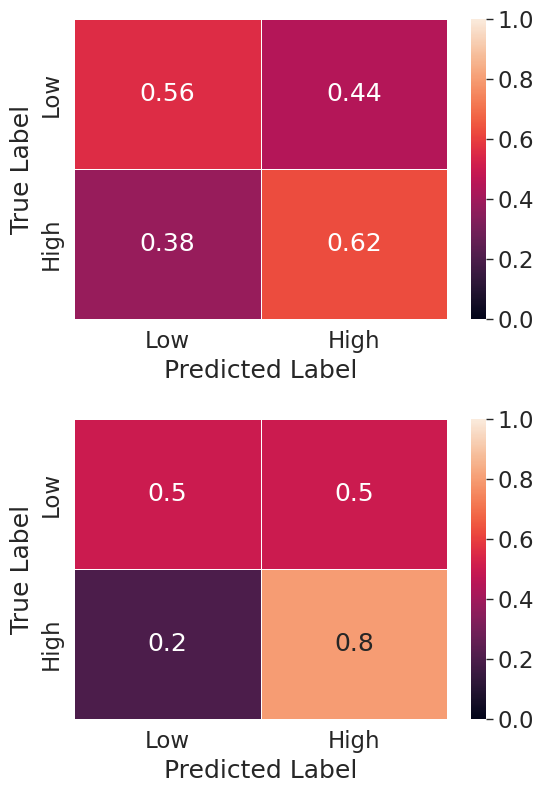

In [100]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(5.845, 8.27))

# Plot section confusion matrix
cf_matrix = s_metrics.confusion_matrix(
    results['section'].label, results['section'].prediction, normalize="true"
)
ax = sns.heatmap(
    cf_matrix, annot=True, linewidths=0.5, ax=axes[0], vmin=0, vmax=1
)
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
ax.set_xticklabels(["Low", "High"])
ax.set_yticklabels(["Low", "High"])

# Plot replica confusion matrix
cf_matrix = s_metrics.confusion_matrix(
    results['replica'].label, results['replica'].prediction, normalize="true"
)
ax = sns.heatmap(
    cf_matrix, annot=True, linewidths=0.5, ax=axes[1], vmin=0, vmax=1
)
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
ax.set_xticklabels(["Low", "High"])
ax.set_yticklabels(["Low", "High"])

# Display plot
plt.tight_layout()
plt.savefig(
    os.path.join(
        FIGURES_PATH, "classification", "normalised_confusion_matrices.pdf"
    ), transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
plt.close()

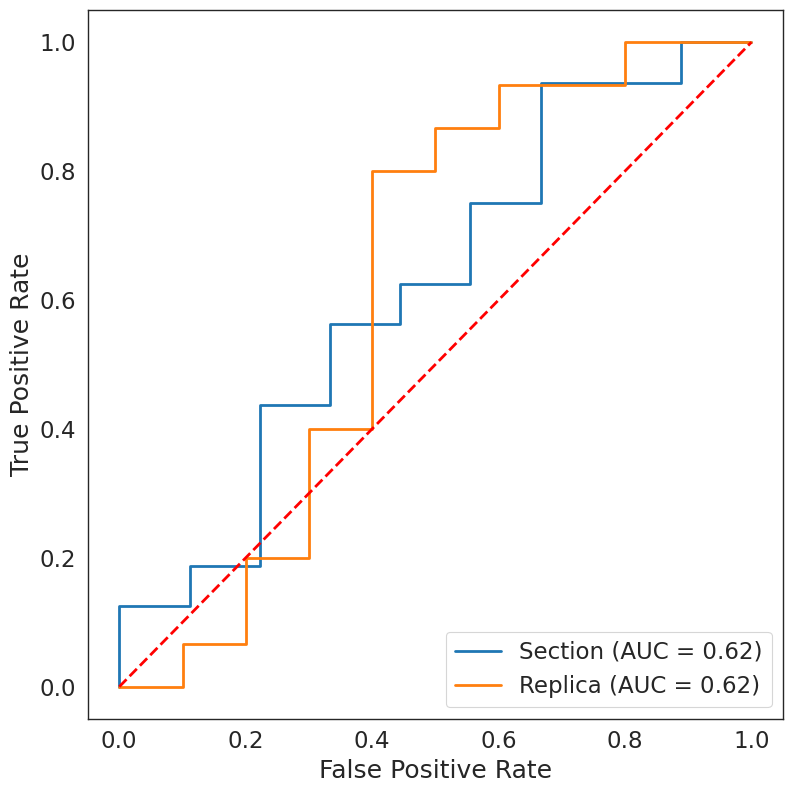

In [101]:
# Define figure size
plt.figure(figsize=(8.27, 8.27))

# Compute Receiver operating characteristic + AUC for section
fpr, tpr, thresholds = s_metrics.roc_curve(
    results['section'].label, results['section'].majority_vote
)
roc_auc = s_metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Section (AUC = {roc_auc:.2f})", linewidth=2)

# Compute Receiver operating characteristic + AUC for replica
fpr, tpr, thresholds = s_metrics.roc_curve(
    results['replica'].label, results['replica'].majority_vote
)
roc_auc = s_metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Replica (AUC = {roc_auc:.2f})", linewidth=2)

# Plot
plt.legend(loc="lower right", fancybox=True, shadow=False)
plt.plot([0, 1], [0, 1], "r--", linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.tight_layout()
plt.savefig(
    os.path.join(
        FIGURES_PATH, "classification",
        "receiver_operator_characteristics_curves.pdf"
    ), transparent=True, bbox_inches='tight', dpi=1200
)
plt.show()
plt.close()

In [96]:
for t in ["section", "replica"]:

  cf_matrix = s_metrics.confusion_matrix(
      results[t].label, results[t].prediction, normalize="true"
  )

  display(pd.DataFrame(cf_matrix, index=["Low", "High"], columns=["Low", "High"]))

,Low,High
Low,0.555556,0.444444
High,0.437500,0.562500


,Low,High
Low,0.600000,0.400000
High,0.333333,0.666667


In [102]:
for t in ["section", "replica"]:
  fpr, tpr, thresholds = s_metrics.roc_curve(
      results[t].label, results[t].majority_vote
  )

  display(pd.DataFrame({
    "fpr": fpr,
    "tpr": tpr,
    "thresholds": thresholds,
  }))

,fpr,tpr,thresholds
0,0.000000,0.0000,inf
1,0.000000,0.0625,0.859450
2,0.000000,0.1250,0.836988
3,0.111111,0.1250,0.794209
4,0.111111,0.1875,0.793937
5,0.222222,0.1875,0.727420
6,0.222222,0.4375,0.635273
7,0.333333,0.4375,0.635138
8,0.333333,0.5625,0.546931
9,0.444444,0.5625,0.542389


,fpr,tpr,thresholds
0,0.0,0.000000,inf
1,0.1,0.000000,0.913993
2,0.1,0.066667,0.909543
3,0.2,0.066667,0.880418
4,0.2,0.200000,0.856038
5,0.3,0.200000,0.820027
6,0.3,0.400000,0.670481
7,0.4,0.400000,0.668719
8,0.4,0.800000,0.514686
9,0.5,0.800000,0.513563
